In [ ]:
!pip install fair-esm optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.8 MB/s eta 0:00:00


In [1]:
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.5 MB/s eta 0:00:00


In [2]:
import torch
#import optuna
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np
import random
import pandas as pd
import torch.nn as nn
import esm
from esm import Alphabet
from torch.utils.data import TensorDataset
#from optuna.samplers import TPESampler
from scipy import stats
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
# === Step 1: Load Pretrained ESM-2 Model ===
MODEL_NAME = "esm2_t6_8M_UR50D"  # smallest esm-2 model
MAX_LEN = 1022
model, alphabet = esm.pretrained.load_model_and_alphabet(MODEL_NAME)
model = model.cuda()
batch_converter = alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [6]:
# Dataset Class
class ProteinDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels, max_length):
        self.sequences = sequences
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        return seq, label  # return the sequence and label as a tuple

# Collate Function with Batch Conversion
def collate_fn(batch):
    # Prepare the data to be in the (label, sequence) format
    batch_labels = [(str(i), seq) for i, (seq, _) in enumerate(batch)]

    # Use batch_converter to tokenize the batch
    _, _, tokens = batch_converter(batch_labels)

    tokens = tokens[:, :MAX_LEN]

    # Get the labels and convert them to tensor
    labels = torch.tensor([label for _, label in batch], dtype=torch.float)

    return tokens.cuda(), labels.cuda()



In [7]:
# === Step 4: Classification Model ===
class ESMClassifier(nn.Module):
    def __init__(self, esm_model, hidden_dim, num_layers, dropout):
        super().__init__()
        self.esm = esm_model  # Keep ESM model as is (for fine-tuning)

        input_dim = self.esm.embed_dim  # Correctly get input dimension from ESM

        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim  # Update for next layer

        layers.append(nn.Linear(hidden_dim, 1))
        self.classifier = nn.Sequential(*layers)

    def forward(self, tokens):
        results = self.esm(tokens, repr_layers=[6], return_contacts=True)
        embeddings = results["representations"][6]
        cls_rep = embeddings[:, 0, :]  # CLS token representation
        logits = self.classifier(cls_rep)
        return logits.view(-1)  # Output shape is [batch_size]


In [21]:
# === Step 5: Training Function ===
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training")
    for x, y in progress_bar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type=device):
            logits = model(x)
            loss = criterion(logits, y.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Metrics
        total_loss += loss.item()
        pred = torch.sigmoid(logits) >= 0.5
        correct += (pred == y).sum().item()
        total += y.size(0)

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{correct/total:.4f}"})


    return total_loss / len(loader), correct / total

In [25]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            logits = model(x)
            loss = criterion(logits, y.float())
            total_loss += loss.item()

            # Convert logits to probabilities and predictions
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            # Store results
            y_true.extend(y.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix to get TN, FP, etc.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Calculate metrics
    metrics = {
        "loss": total_loss / len(loader),
        "accuracy": accuracy_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_prob),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "specificity": specificity,
        "mcc": matthews_corrcoef(y_true, y_pred),
    }

    for name, value in metrics.items():
        print(f"{name:12}: {value:.4f}")

    return metrics, y_true, y_prob


In [ ]:
def objective(trial):
    # Hyperparameters
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-5)
    batch_size = trial.suggest_categorical("batch_size", [4,8]) #Due to limited computation resources available
    max_epochs = trial.suggest_int("max_epochs", 3, 10)

    # 5-Fold CV on training dataset
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    val_scores = []
    plt.figure(figsize=(10, 8))

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_sequences)):
        fold_train_seqs = [train_sequences[i] for i in train_idx]
        fold_train_labels = [train_labels[i] for i in train_idx]
        fold_val_seqs = [train_sequences[i] for i in val_idx]
        fold_val_labels = [train_labels[i] for i in val_idx]

        fold_train_dataset = ProteinDataset(fold_train_seqs, fold_train_labels, MAX_LEN)
        fold_val_dataset = ProteinDataset(fold_val_seqs, fold_val_labels, MAX_LEN)

        train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(fold_val_dataset, batch_size=batch_size, collate_fn=collate_fn)

        # Load ESM model
        esm_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
        esm_model = esm_model.cuda()
        model = ESMClassifier(esm_model, hidden_dim, num_layers, dropout).cuda()

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()
        scaler = GradScaler()
        early_stopping = EarlyStopping(patience=3, min_delta=1e-3)

        for epoch in range(max_epochs):
            train_epoch(model, train_loader, criterion, optimizer, scaler, device)
            metrics = evaluate(model, val_loader, criterion, device="cuda")

            # Report intermediate value to Optuna (key for pruning)
            trial.report(metrics["loss"], step=epoch)

            # Check if trial should be pruned
            if trial.should_prune():
                print(f"Pruned fold {fold+1} at epoch {epoch+1}")
                raise optuna.exceptions.TrialPruned()

            print(f"Fold {fold+1}, Epoch {epoch+1}: AUC = {metrics['auc']:.4f}")
            early_stopping.step(metrics["auc"])
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1} for fold {fold+1}")
                break

        val_scores.append(metrics["loss"])

        # ROC curve
        model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb)
                probs = torch.sigmoid(logits).view(-1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        RocCurveDisplay.from_predictions(all_labels, all_probs, name=f"Fold {fold+1}", ax=plt.gca())

    plt.title("ROC Curve - Cross-Validation Folds")
    plt.legend()
    plt.show()

    # Save the CV scores
    trial.set_user_attr("cv_scores", val_scores)

    mean_loss = np.mean(val_scores)
    print(f"Cross-Validation Losses: {val_scores}")
    return mean_loss


In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def step(self, score):
        if self.best_score is None or score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# === Load Your Data ===
# Load pre-split datasets
train_csv_path = "/content/drive/MyDrive/algpred2_fine-tuning_train.csv"
test_csv_path = "/content/drive/MyDrive/algpred2_fine-tuning_test.csv"
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

# Extract sequences and labels
train_sequences = df_train["sequence"].tolist()
train_labels = df_train["label"].tolist()


test_sequences = df_test["sequence"].tolist()
test_labels = df_test["label"].tolist()

[I 2025-05-14 21:53:11,246] A new study created in memory with name: no-name-d615ba6d-401a-4480-abec-e6d37f40baa2
<ipython-input-19-abad7e40b256>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-5)
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 2398/2398 [02:05<00:00, 19.11it/s, loss=0.0276, acc=0.9137]


loss        : 0.1547
accuracy    : 0.9558
auc         : 0.9879
f1          : 0.9562
precision   : 0.9469
recall      : 0.9658
mcc         : 0.9118
Fold 1, Epoch 1: AUC = 0.9879


Training: 100%|██████████| 2398/2398 [02:05<00:00, 19.10it/s, loss=0.0201, acc=0.9661]


loss        : 0.1152
accuracy    : 0.9616
auc         : 0.9917
f1          : 0.9614
precision   : 0.9679
recall      : 0.9550
mcc         : 0.9234
Fold 1, Epoch 2: AUC = 0.9917


Training: 100%|██████████| 2398/2398 [02:05<00:00, 19.08it/s, loss=0.0182, acc=0.9798]


loss        : 0.0986
accuracy    : 0.9683
auc         : 0.9945
f1          : 0.9679
precision   : 0.9811
recall      : 0.9550
mcc         : 0.9369
Fold 1, Epoch 3: AUC = 0.9945


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.96it/s, loss=0.0056, acc=0.9878]


loss        : 0.0965
accuracy    : 0.9708
auc         : 0.9940
f1          : 0.9709
precision   : 0.9669
recall      : 0.9750
mcc         : 0.9417
Fold 1, Epoch 4: AUC = 0.9940


Training: 100%|██████████| 2398/2398 [02:05<00:00, 19.04it/s, loss=0.0086, acc=0.9929]


loss        : 0.1179
accuracy    : 0.9687
auc         : 0.9938
f1          : 0.9691
precision   : 0.9577
recall      : 0.9808
mcc         : 0.9377
Fold 1, Epoch 5: AUC = 0.9938


Training: 100%|██████████| 2398/2398 [02:05<00:00, 19.09it/s, loss=0.0062, acc=0.9955]


loss        : 0.1037
accuracy    : 0.9729
auc         : 0.9942
f1          : 0.9732
precision   : 0.9640
recall      : 0.9825
mcc         : 0.9460
Fold 1, Epoch 6: AUC = 0.9942
Early stopping at epoch 6 for fold 1


<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.94it/s, loss=0.0601, acc=0.9198]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.1454
accuracy    : 0.9583
auc         : 0.9876
f1          : 0.9572
precision   : 0.9696
recall      : 0.9451
mcc         : 0.9168
Fold 2, Epoch 1: AUC = 0.9876


Training: 100%|██████████| 2398/2398 [02:06<00:00, 19.00it/s, loss=0.0231, acc=0.9648]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.1235
accuracy    : 0.9621
auc         : 0.9905
f1          : 0.9617
precision   : 0.9573
recall      : 0.9662
mcc         : 0.9241
Fold 2, Epoch 2: AUC = 0.9905


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.99it/s, loss=0.0137, acc=0.9770]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.1021
accuracy    : 0.9666
auc         : 0.9931
f1          : 0.9665
precision   : 0.9577
recall      : 0.9755
mcc         : 0.9334
Fold 2, Epoch 3: AUC = 0.9931


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.98it/s, loss=0.0042, acc=0.9852]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.0904
accuracy    : 0.9708
auc         : 0.9945
f1          : 0.9707
precision   : 0.9603
recall      : 0.9814
mcc         : 0.9418
Fold 2, Epoch 4: AUC = 0.9945


Training: 100%|██████████| 2398/2398 [02:06<00:00, 19.00it/s, loss=0.0017, acc=0.9919]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.1104
accuracy    : 0.9712
auc         : 0.9934
f1          : 0.9712
precision   : 0.9596
recall      : 0.9831
mcc         : 0.9427
Fold 2, Epoch 5: AUC = 0.9934


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.91it/s, loss=0.0015, acc=0.9946]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


loss        : 0.0957
accuracy    : 0.9754
auc         : 0.9941
f1          : 0.9751
precision   : 0.9739
recall      : 0.9763
mcc         : 0.9508
Fold 2, Epoch 6: AUC = 0.9941


Training: 100%|██████████| 2398/2398 [02:06<00:00, 19.00it/s, loss=0.0008, acc=0.9982]


loss        : 0.1085
accuracy    : 0.9779
auc         : 0.9950
f1          : 0.9778
precision   : 0.9708
recall      : 0.9848
mcc         : 0.9559
Fold 2, Epoch 7: AUC = 0.9950
Early stopping at epoch 7 for fold 2


<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.74it/s, loss=0.0402, acc=0.9236]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.1707
accuracy    : 0.9454
auc         : 0.9815
f1          : 0.9454
precision   : 0.9635
recall      : 0.9280
mcc         : 0.8914
Fold 3, Epoch 1: AUC = 0.9815


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.76it/s, loss=0.0419, acc=0.9663]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.1327
accuracy    : 0.9629
auc         : 0.9891
f1          : 0.9638
precision   : 0.9587
recall      : 0.9689
mcc         : 0.9258
Fold 3, Epoch 2: AUC = 0.9891


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.79it/s, loss=0.0097, acc=0.9782]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.1008
accuracy    : 0.9696
auc         : 0.9921
f1          : 0.9702
precision   : 0.9675
recall      : 0.9730
mcc         : 0.9391
Fold 3, Epoch 3: AUC = 0.9921


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.69it/s, loss=0.0056, acc=0.9860]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.0907
accuracy    : 0.9771
auc         : 0.9921
f1          : 0.9775
precision   : 0.9763
recall      : 0.9787
mcc         : 0.9541
Fold 3, Epoch 4: AUC = 0.9921


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.76it/s, loss=0.0043, acc=0.9918]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.0985
accuracy    : 0.9791
auc         : 0.9930
f1          : 0.9797
precision   : 0.9726
recall      : 0.9869
mcc         : 0.9584
Fold 3, Epoch 5: AUC = 0.9930


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.74it/s, loss=0.0041, acc=0.9950]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


loss        : 0.0961
accuracy    : 0.9808
auc         : 0.9932
f1          : 0.9813
precision   : 0.9765
recall      : 0.9861
mcc         : 0.9617
Fold 3, Epoch 6: AUC = 0.9932


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.77it/s, loss=0.0006, acc=0.9958]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


loss        : 0.1177
accuracy    : 0.9741
auc         : 0.9916
f1          : 0.9746
precision   : 0.9762
recall      : 0.9730
mcc         : 0.9483
Fold 3, Epoch 7: AUC = 0.9916


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.87it/s, loss=0.0006, acc=0.9979]


loss        : 0.1376
accuracy    : 0.9737
auc         : 0.9903
f1          : 0.9744
precision   : 0.9670
recall      : 0.9820
mcc         : 0.9475
Fold 3, Epoch 8: AUC = 0.9903


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.77it/s, loss=0.0004, acc=0.9973]


loss        : 0.1199
accuracy    : 0.9766
auc         : 0.9931
f1          : 0.9773
precision   : 0.9679
recall      : 0.9869
mcc         : 0.9534
Fold 3, Epoch 9: AUC = 0.9931
Early stopping at epoch 9 for fold 3


<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.87it/s, loss=0.0486, acc=0.9245]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.1421
accuracy    : 0.9599
auc         : 0.9864
f1          : 0.9598
precision   : 0.9606
recall      : 0.9590
mcc         : 0.9199
Fold 4, Epoch 1: AUC = 0.9864


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.86it/s, loss=0.0365, acc=0.9689]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.1067
accuracy    : 0.9708
auc         : 0.9929
f1          : 0.9708
precision   : 0.9699
recall      : 0.9716
mcc         : 0.9416
Fold 4, Epoch 2: AUC = 0.9929


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.89it/s, loss=0.1419, acc=0.9788]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.1121
accuracy    : 0.9633
auc         : 0.9943
f1          : 0.9638
precision   : 0.9475
recall      : 0.9808
mcc         : 0.9271
Fold 4, Epoch 3: AUC = 0.9943


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.88it/s, loss=0.0058, acc=0.9875]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.0783
accuracy    : 0.9787
auc         : 0.9948
f1          : 0.9786
precision   : 0.9831
recall      : 0.9741
mcc         : 0.9575
Fold 4, Epoch 4: AUC = 0.9948


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.91it/s, loss=0.0194, acc=0.9944]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.0824
accuracy    : 0.9804
auc         : 0.9959
f1          : 0.9804
precision   : 0.9776
recall      : 0.9833
mcc         : 0.9608
Fold 4, Epoch 5: AUC = 0.9959


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.87it/s, loss=0.0029, acc=0.9954]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


loss        : 0.0822
accuracy    : 0.9808
auc         : 0.9953
f1          : 0.9809
precision   : 0.9760
recall      : 0.9858
mcc         : 0.9617
Fold 4, Epoch 6: AUC = 0.9953


Training: 100%|██████████| 2398/2398 [02:07<00:00, 18.87it/s, loss=0.0042, acc=0.9970]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


loss        : 0.1118
accuracy    : 0.9741
auc         : 0.9950
f1          : 0.9745
precision   : 0.9602
recall      : 0.9891
mcc         : 0.9487
Fold 4, Epoch 7: AUC = 0.9950


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.92it/s, loss=0.0018, acc=0.9973]


loss        : 0.0951
accuracy    : 0.9804
auc         : 0.9945
f1          : 0.9804
precision   : 0.9760
recall      : 0.9849
mcc         : 0.9608
Fold 4, Epoch 8: AUC = 0.9945
Early stopping at epoch 8 for fold 4


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.97it/s, loss=0.0522, acc=0.9197]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.1465
accuracy    : 0.9537
auc         : 0.9879
f1          : 0.9534
precision   : 0.9554
recall      : 0.9514
mcc         : 0.9074
Fold 5, Epoch 1: AUC = 0.9879


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.89it/s, loss=0.1403, acc=0.9668]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.1444
accuracy    : 0.9537
auc         : 0.9915
f1          : 0.9546
precision   : 0.9321
recall      : 0.9782
mcc         : 0.9085
Fold 5, Epoch 2: AUC = 0.9915


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.91it/s, loss=0.0062, acc=0.9779]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.0996
accuracy    : 0.9679
auc         : 0.9927
f1          : 0.9674
precision   : 0.9786
recall      : 0.9564
mcc         : 0.9360
Fold 5, Epoch 3: AUC = 0.9927


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.89it/s, loss=0.0074, acc=0.9877]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.1097
accuracy    : 0.9658
auc         : 0.9931
f1          : 0.9661
precision   : 0.9520
recall      : 0.9807
mcc         : 0.9320
Fold 5, Epoch 4: AUC = 0.9931


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.99it/s, loss=0.0023, acc=0.9910]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.1090
accuracy    : 0.9704
auc         : 0.9932
f1          : 0.9707
precision   : 0.9554
recall      : 0.9866
mcc         : 0.9413
Fold 5, Epoch 5: AUC = 0.9932


Training: 100%|██████████| 2398/2398 [02:06<00:00, 18.93it/s, loss=0.0005, acc=0.9964]


loss        : 0.1500
accuracy    : 0.9650
auc         : 0.9927
f1          : 0.9656
precision   : 0.9440
recall      : 0.9883
mcc         : 0.9309
Fold 5, Epoch 6: AUC = 0.9927
Early stopping at epoch 6 for fold 5


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


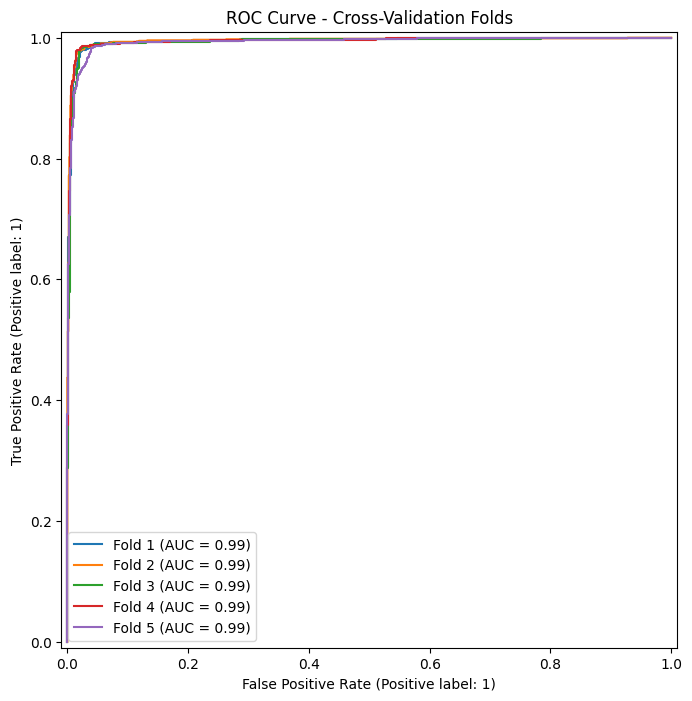

[I 2025-05-14 23:23:46,558] Trial 0 finished with value: 0.11541547279738493 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.10582998499416787, 'lr': 8.293674908605468e-06, 'batch_size': 4, 'max_epochs': 10}. Best is trial 0 with value: 0.11541547279738493.
<ipython-input-19-abad7e40b256>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-5)
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Cross-Validation Losses: [0.1036558879223109, 0.10848582465332583, 0.11990968063544036, 0.09506684942888873, 0.14995912134695877]


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.72it/s, loss=0.6977, acc=0.5262]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


loss        : 0.6882
accuracy    : 0.5000
auc         : 0.9123
f1          : 0.0000
precision   : 0.0000
recall      : 0.0000
mcc         : 0.0000
Fold 1, Epoch 1: AUC = 0.9123


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.75it/s, loss=0.6960, acc=0.6654]


loss        : 0.6658
accuracy    : 0.8824
auc         : 0.9309
f1          : 0.8797
precision   : 0.9004
recall      : 0.8599
mcc         : 0.7656
Fold 1, Epoch 2: AUC = 0.9309


Training: 100%|██████████| 1199/1199 [02:02<00:00,  9.77it/s, loss=0.6186, acc=0.8670]


loss        : 0.6080
accuracy    : 0.9116
auc         : 0.9686
f1          : 0.9140
precision   : 0.8895
recall      : 0.9399
mcc         : 0.8245
Fold 1, Epoch 3: AUC = 0.9686


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.71it/s, loss=0.5532, acc=0.9194]


loss        : 0.5326
accuracy    : 0.9312
auc         : 0.9758
f1          : 0.9321
precision   : 0.9196
recall      : 0.9450
mcc         : 0.8627
Fold 1, Epoch 4: AUC = 0.9758


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.74it/s, loss=0.4813, acc=0.9373]


loss        : 0.4457
accuracy    : 0.9416
auc         : 0.9782
f1          : 0.9423
precision   : 0.9308
recall      : 0.9541
mcc         : 0.8835
Fold 1, Epoch 5: AUC = 0.9782


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.73it/s, loss=0.3619, acc=0.9501]


loss        : 0.3614
accuracy    : 0.9520
auc         : 0.9767
f1          : 0.9517
precision   : 0.9585
recall      : 0.9450
mcc         : 0.9042
Fold 1, Epoch 6: AUC = 0.9767


<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.67it/s, loss=0.6889, acc=0.5163]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.6889
accuracy    : 0.6501
auc         : 0.8615
f1          : 0.4912
precision   : 0.8691
recall      : 0.3423
mcc         : 0.3691
Fold 2, Epoch 1: AUC = 0.8615


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.71it/s, loss=0.6875, acc=0.6454]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.6728
accuracy    : 0.8636
auc         : 0.9101
f1          : 0.8592
precision   : 0.8754
recall      : 0.8436
mcc         : 0.7276
Fold 2, Epoch 2: AUC = 0.9101


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.61it/s, loss=0.6369, acc=0.8319]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.6306
accuracy    : 0.9087
auc         : 0.9457
f1          : 0.9096
precision   : 0.8887
recall      : 0.9315
mcc         : 0.8184
Fold 2, Epoch 3: AUC = 0.9457


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.69it/s, loss=0.5504, acc=0.9114]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.5616
accuracy    : 0.9212
auc         : 0.9629
f1          : 0.9213
precision   : 0.9080
recall      : 0.9349
mcc         : 0.8428
Fold 2, Epoch 4: AUC = 0.9629


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.72it/s, loss=0.6968, acc=0.9308]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.4717
accuracy    : 0.9379
auc         : 0.9698
f1          : 0.9378
precision   : 0.9259
recall      : 0.9501
mcc         : 0.8760
Fold 2, Epoch 5: AUC = 0.9698


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.66it/s, loss=0.3554, acc=0.9426]


loss        : 0.3798
accuracy    : 0.9454
auc         : 0.9747
f1          : 0.9448
precision   : 0.9413
recall      : 0.9484
mcc         : 0.8908
Fold 2, Epoch 6: AUC = 0.9747


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:06<00:00,  9.48it/s, loss=0.6898, acc=0.5315]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.6815
accuracy    : 0.7335
auc         : 0.8973
f1          : 0.7899
precision   : 0.6606
recall      : 0.9820
mcc         : 0.5334
Fold 3, Epoch 1: AUC = 0.8973


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.58it/s, loss=0.6381, acc=0.7096]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.6453
accuracy    : 0.8907
auc         : 0.9396
f1          : 0.8992
precision   : 0.8489
recall      : 0.9558
mcc         : 0.7874
Fold 3, Epoch 2: AUC = 0.9396


Training: 100%|██████████| 1199/1199 [02:06<00:00,  9.50it/s, loss=0.5858, acc=0.8765]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.5828
accuracy    : 0.9195
auc         : 0.9646
f1          : 0.9235
precision   : 0.8962
recall      : 0.9526
mcc         : 0.8405
Fold 3, Epoch 3: AUC = 0.9646


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.55it/s, loss=0.5202, acc=0.9251]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.4992
accuracy    : 0.9316
auc         : 0.9711
f1          : 0.9338
precision   : 0.9219
recall      : 0.9460
mcc         : 0.8634
Fold 3, Epoch 4: AUC = 0.9711


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.55it/s, loss=0.4919, acc=0.9434]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.4070
accuracy    : 0.9383
auc         : 0.9748
f1          : 0.9396
precision   : 0.9381
recall      : 0.9411
mcc         : 0.8765
Fold 3, Epoch 5: AUC = 0.9748


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.62it/s, loss=0.3271, acc=0.9498]


loss        : 0.3230
accuracy    : 0.9475
auc         : 0.9768
f1          : 0.9482
precision   : 0.9537
recall      : 0.9428
mcc         : 0.8950
Fold 3, Epoch 6: AUC = 0.9768


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.67it/s, loss=0.6879, acc=0.5051]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.6836
accuracy    : 0.5010
auc         : 0.9418
f1          : 0.0000
precision   : 0.0000
recall      : 0.0000
mcc         : 0.0000
Fold 4, Epoch 1: AUC = 0.9418


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.55it/s, loss=0.5891, acc=0.6026]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.6323
accuracy    : 0.9057
auc         : 0.9681
f1          : 0.9003
precision   : 0.9533
recall      : 0.8528
mcc         : 0.8159
Fold 4, Epoch 2: AUC = 0.9681


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.64it/s, loss=0.5068, acc=0.8341]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.5495
accuracy    : 0.9378
auc         : 0.9738
f1          : 0.9366
precision   : 0.9540
recall      : 0.9197
mcc         : 0.8762
Fold 4, Epoch 3: AUC = 0.9738


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.66it/s, loss=0.4037, acc=0.9322]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.4579
accuracy    : 0.9416
auc         : 0.9750
f1          : 0.9415
precision   : 0.9415
recall      : 0.9415
mcc         : 0.8832
Fold 4, Epoch 4: AUC = 0.9750


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.60it/s, loss=0.4520, acc=0.9501]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.3674
accuracy    : 0.9516
auc         : 0.9773
f1          : 0.9511
precision   : 0.9584
recall      : 0.9440
mcc         : 0.9033
Fold 4, Epoch 5: AUC = 0.9773


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.65it/s, loss=0.2874, acc=0.9576]


loss        : 0.2943
accuracy    : 0.9524
auc         : 0.9788
f1          : 0.9523
precision   : 0.9531
recall      : 0.9515
mcc         : 0.9049
Fold 4, Epoch 6: AUC = 0.9788


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.72it/s, loss=0.6931, acc=0.5187]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.6797
accuracy    : 0.6249
auc         : 0.9435
f1          : 0.4066
precision   : 0.9565
recall      : 0.2582
mcc         : 0.3615
Fold 5, Epoch 1: AUC = 0.9435


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.68it/s, loss=0.6139, acc=0.7258]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.6194
accuracy    : 0.9241
auc         : 0.9700
f1          : 0.9232
precision   : 0.9295
recall      : 0.9170
mcc         : 0.8482
Fold 5, Epoch 2: AUC = 0.9700


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.68it/s, loss=0.4625, acc=0.8982]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.5333
accuracy    : 0.9353
auc         : 0.9728
f1          : 0.9341
precision   : 0.9474
recall      : 0.9212
mcc         : 0.8710
Fold 5, Epoch 3: AUC = 0.9728


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.70it/s, loss=0.3771, acc=0.9387]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.4426
accuracy    : 0.9441
auc         : 0.9752
f1          : 0.9442
precision   : 0.9380
recall      : 0.9505
mcc         : 0.8883
Fold 5, Epoch 4: AUC = 0.9752


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.63it/s, loss=0.3728, acc=0.9504]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.3553
accuracy    : 0.9508
auc         : 0.9778
f1          : 0.9504
precision   : 0.9536
recall      : 0.9472
mcc         : 0.9016
Fold 5, Epoch 5: AUC = 0.9778


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.63it/s, loss=0.2462, acc=0.9537]


loss        : 0.2843
accuracy    : 0.9483
auc         : 0.9789
f1          : 0.9481
precision   : 0.9473
recall      : 0.9489
mcc         : 0.8965
Fold 5, Epoch 6: AUC = 0.9789


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


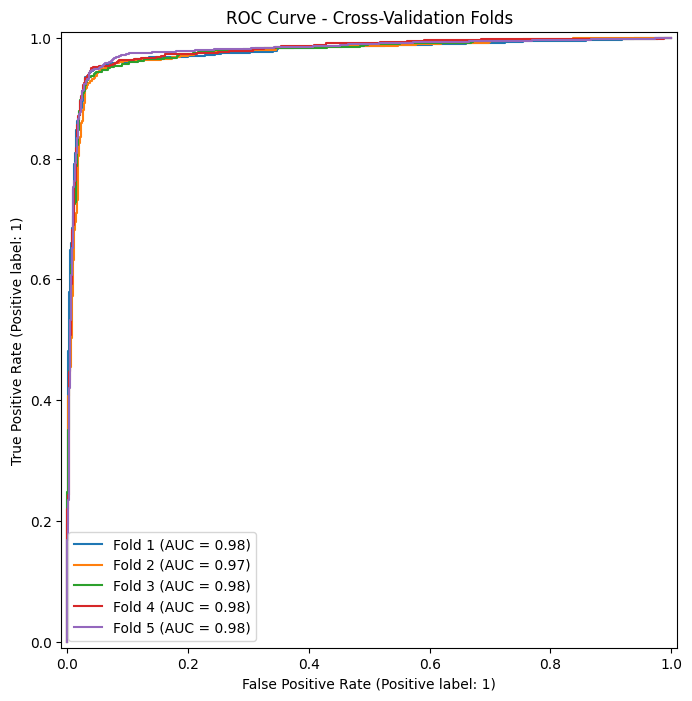

[I 2025-05-15 00:40:33,794] Trial 1 finished with value: 0.3285929692884286 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.44109421644371405, 'lr': 1.0052156317193808e-06, 'batch_size': 8, 'max_epochs': 6}. Best is trial 0 with value: 0.11541547279738493.
<ipython-input-19-abad7e40b256>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-5)
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Cross-Validation Losses: [0.3614491021136443, 0.37984964112440744, 0.3230125978589058, 0.29430453663071, 0.2843489687144756]


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.73it/s, loss=0.4550, acc=0.7951]


loss        : 0.4625
accuracy    : 0.9066
auc         : 0.9526
f1          : 0.9075
precision   : 0.8986
recall      : 0.9166
mcc         : 0.8133
Fold 1, Epoch 1: AUC = 0.9526


Training: 100%|██████████| 1199/1199 [02:02<00:00,  9.75it/s, loss=0.3848, acc=0.9248]


loss        : 0.3089
accuracy    : 0.9362
auc         : 0.9750
f1          : 0.9368
precision   : 0.9287
recall      : 0.9450
mcc         : 0.8725
Fold 1, Epoch 2: AUC = 0.9750


Training: 100%|██████████| 1199/1199 [02:02<00:00,  9.75it/s, loss=0.1535, acc=0.9438]


loss        : 0.2451
accuracy    : 0.9433
auc         : 0.9812
f1          : 0.9439
precision   : 0.9332
recall      : 0.9550
mcc         : 0.8868
Fold 1, Epoch 3: AUC = 0.9812


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.68it/s, loss=0.4146, acc=0.9537]


loss        : 0.2116
accuracy    : 0.9491
auc         : 0.9840
f1          : 0.9494
precision   : 0.9447
recall      : 0.9541
mcc         : 0.8983
Fold 1, Epoch 4: AUC = 0.9840


Training: 100%|██████████| 1199/1199 [02:02<00:00,  9.80it/s, loss=0.1335, acc=0.9594]


loss        : 0.1894
accuracy    : 0.9500
auc         : 0.9857
f1          : 0.9503
precision   : 0.9440
recall      : 0.9566
mcc         : 0.9000
Fold 1, Epoch 5: AUC = 0.9857


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.73it/s, loss=0.5072, acc=0.9658]


loss        : 0.1743
accuracy    : 0.9545
auc         : 0.9866
f1          : 0.9550
precision   : 0.9453
recall      : 0.9650
mcc         : 0.9093
Fold 1, Epoch 6: AUC = 0.9866


<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.60it/s, loss=0.5704, acc=0.7413]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.4349
accuracy    : 0.9053
auc         : 0.9644
f1          : 0.9063
precision   : 0.8855
recall      : 0.9281
mcc         : 0.8117
Fold 2, Epoch 1: AUC = 0.9644


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.73it/s, loss=0.2556, acc=0.9241]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.3014
accuracy    : 0.9345
auc         : 0.9747
f1          : 0.9340
precision   : 0.9296
recall      : 0.9383
mcc         : 0.8691
Fold 2, Epoch 2: AUC = 0.9747


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.69it/s, loss=0.1916, acc=0.9423]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.2417
accuracy    : 0.9458
auc         : 0.9788
f1          : 0.9454
precision   : 0.9398
recall      : 0.9510
mcc         : 0.8916
Fold 2, Epoch 3: AUC = 0.9788


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.68it/s, loss=0.4580, acc=0.9533]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.2090
accuracy    : 0.9504
auc         : 0.9815
f1          : 0.9499
precision   : 0.9471
recall      : 0.9527
mcc         : 0.9008
Fold 2, Epoch 4: AUC = 0.9815


Training: 100%|██████████| 1199/1199 [02:02<00:00,  9.76it/s, loss=0.1198, acc=0.9594]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.1868
accuracy    : 0.9550
auc         : 0.9835
f1          : 0.9544
precision   : 0.9544
recall      : 0.9544
mcc         : 0.9099
Fold 2, Epoch 5: AUC = 0.9835


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.72it/s, loss=0.1112, acc=0.9612]


loss        : 0.1728
accuracy    : 0.9541
auc         : 0.9844
f1          : 0.9535
precision   : 0.9543
recall      : 0.9527
mcc         : 0.9082
Fold 2, Epoch 6: AUC = 0.9844


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.53it/s, loss=0.7295, acc=0.8519]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.3929
accuracy    : 0.9237
auc         : 0.9711
f1          : 0.9261
precision   : 0.9153
recall      : 0.9370
mcc         : 0.8475
Fold 3, Epoch 1: AUC = 0.9711


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.59it/s, loss=0.2152, acc=0.9397]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.2685
accuracy    : 0.9429
auc         : 0.9762
f1          : 0.9436
precision   : 0.9495
recall      : 0.9379
mcc         : 0.8858
Fold 3, Epoch 2: AUC = 0.9762


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.55it/s, loss=0.1126, acc=0.9530]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.2202
accuracy    : 0.9520
auc         : 0.9781
f1          : 0.9528
precision   : 0.9556
recall      : 0.9501
mcc         : 0.9041
Fold 3, Epoch 3: AUC = 0.9781


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.60it/s, loss=0.1258, acc=0.9568]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.1967
accuracy    : 0.9541
auc         : 0.9796
f1          : 0.9552
precision   : 0.9521
recall      : 0.9583
mcc         : 0.9082
Fold 3, Epoch 4: AUC = 0.9796


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.55it/s, loss=0.0968, acc=0.9626]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.1763
accuracy    : 0.9575
auc         : 0.9806
f1          : 0.9578
precision   : 0.9690
recall      : 0.9469
mcc         : 0.9152
Fold 3, Epoch 5: AUC = 0.9806


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.61it/s, loss=0.0736, acc=0.9654]


loss        : 0.1635
accuracy    : 0.9595
auc         : 0.9818
f1          : 0.9600
precision   : 0.9684
recall      : 0.9518
mcc         : 0.9192
Fold 3, Epoch 6: AUC = 0.9818


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.57it/s, loss=0.5329, acc=0.8010]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.4100
accuracy    : 0.9266
auc         : 0.9712
f1          : 0.9256
precision   : 0.9359
recall      : 0.9156
mcc         : 0.8533
Fold 4, Epoch 1: AUC = 0.9712


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.56it/s, loss=0.5691, acc=0.9353]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.2773
accuracy    : 0.9433
auc         : 0.9785
f1          : 0.9428
precision   : 0.9492
recall      : 0.9365
mcc         : 0.8866
Fold 4, Epoch 2: AUC = 0.9785


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.57it/s, loss=0.2158, acc=0.9494]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.2251
accuracy    : 0.9508
auc         : 0.9801
f1          : 0.9503
precision   : 0.9568
recall      : 0.9440
mcc         : 0.9016
Fold 4, Epoch 3: AUC = 0.9801


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.59it/s, loss=0.1250, acc=0.9582]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.2003
accuracy    : 0.9504
auc         : 0.9829
f1          : 0.9502
precision   : 0.9506
recall      : 0.9498
mcc         : 0.9007
Fold 4, Epoch 4: AUC = 0.9829


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.64it/s, loss=0.1011, acc=0.9610]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.1783
accuracy    : 0.9533
auc         : 0.9836
f1          : 0.9530
precision   : 0.9570
recall      : 0.9490
mcc         : 0.9066
Fold 4, Epoch 5: AUC = 0.9836


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.55it/s, loss=0.1020, acc=0.9647]


loss        : 0.1713
accuracy    : 0.9520
auc         : 0.9848
f1          : 0.9521
precision   : 0.9485
recall      : 0.9557
mcc         : 0.9041
Fold 4, Epoch 6: AUC = 0.9848


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.68it/s, loss=0.4087, acc=0.8239]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.4195
accuracy    : 0.9195
auc         : 0.9645
f1          : 0.9194
precision   : 0.9160
recall      : 0.9229
mcc         : 0.8390
Fold 5, Epoch 1: AUC = 0.9645


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.63it/s, loss=0.2749, acc=0.9333]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.2837
accuracy    : 0.9433
auc         : 0.9758
f1          : 0.9429
precision   : 0.9445
recall      : 0.9413
mcc         : 0.8865
Fold 5, Epoch 2: AUC = 0.9758


Training: 100%|██████████| 1199/1199 [02:04<00:00,  9.63it/s, loss=0.5217, acc=0.9513]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.2312
accuracy    : 0.9483
auc         : 0.9783
f1          : 0.9471
precision   : 0.9636
recall      : 0.9313
mcc         : 0.8970
Fold 5, Epoch 3: AUC = 0.9783


Training: 100%|██████████| 1199/1199 [02:05<00:00,  9.59it/s, loss=0.1095, acc=0.9570]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.1979
accuracy    : 0.9541
auc         : 0.9802
f1          : 0.9537
precision   : 0.9577
recall      : 0.9497
mcc         : 0.9082
Fold 5, Epoch 4: AUC = 0.9802


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.67it/s, loss=0.0901, acc=0.9610]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.1784
accuracy    : 0.9554
auc         : 0.9813
f1          : 0.9552
precision   : 0.9548
recall      : 0.9556
mcc         : 0.9107
Fold 5, Epoch 5: AUC = 0.9813


Training: 100%|██████████| 1199/1199 [02:03<00:00,  9.69it/s, loss=0.0821, acc=0.9650]


loss        : 0.1631
accuracy    : 0.9587
auc         : 0.9826
f1          : 0.9582
precision   : 0.9659
recall      : 0.9505
mcc         : 0.9175
Fold 5, Epoch 6: AUC = 0.9826


/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


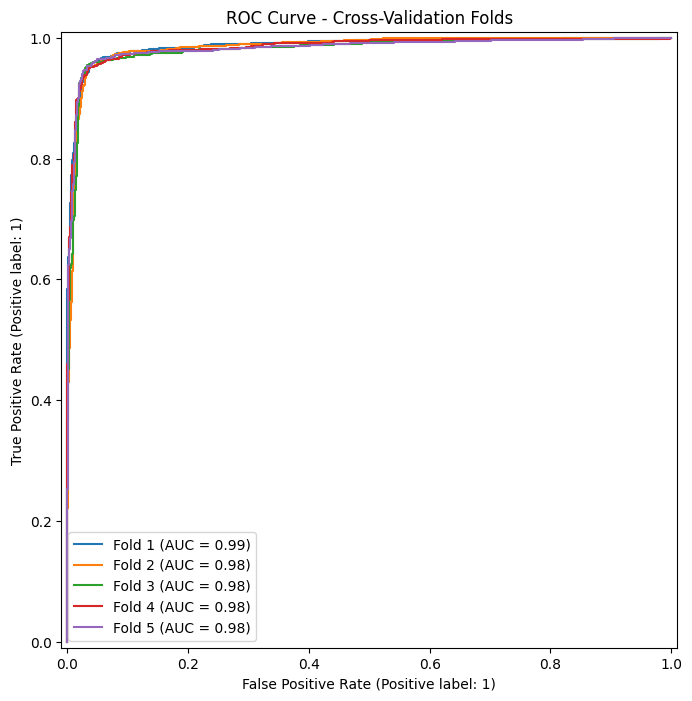

[I 2025-05-15 01:57:22,945] Trial 2 finished with value: 0.16901979108403128 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.15408407134764676, 'lr': 1.3069922651243291e-06, 'batch_size': 8, 'max_epochs': 6}. Best is trial 0 with value: 0.11541547279738493.
<ipython-input-19-abad7e40b256>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-5)
<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Cross-Validation Losses: [0.1743405337134997, 0.1728436296681563, 0.1635418634985884, 0.1713198064515988, 0.1630531220883131]


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.69it/s, loss=0.8027, acc=0.8205]


loss        : 0.5297
accuracy    : 0.9254
auc         : 0.9716
f1          : 0.9260
precision   : 0.9180
recall      : 0.9341
mcc         : 0.8508
Fold 1, Epoch 1: AUC = 0.9716


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.62it/s, loss=0.4001, acc=0.9407]


loss        : 0.3693
accuracy    : 0.9454
auc         : 0.9783
f1          : 0.9447
precision   : 0.9556
recall      : 0.9341
mcc         : 0.8910
Fold 1, Epoch 2: AUC = 0.9783


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.67it/s, loss=0.1424, acc=0.9548]


loss        : 0.2565
accuracy    : 0.9516
auc         : 0.9827
f1          : 0.9521
precision   : 0.9435
recall      : 0.9608
mcc         : 0.9034
Fold 1, Epoch 3: AUC = 0.9827


Training: 100%|██████████| 2398/2398 [02:09<00:00, 18.58it/s, loss=0.1069, acc=0.9610]


loss        : 0.1932
accuracy    : 0.9525
auc         : 0.9852
f1          : 0.9527
precision   : 0.9472
recall      : 0.9583
mcc         : 0.9050
Fold 1, Epoch 4: AUC = 0.9852


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.66it/s, loss=0.0692, acc=0.9665]


loss        : 0.1579
accuracy    : 0.9604
auc         : 0.9876
f1          : 0.9604
precision   : 0.9600
recall      : 0.9608
mcc         : 0.9208
Fold 1, Epoch 5: AUC = 0.9876


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.65it/s, loss=0.0306, acc=0.9714]


loss        : 0.1459
accuracy    : 0.9616
auc         : 0.9883
f1          : 0.9617
precision   : 0.9601
recall      : 0.9633
mcc         : 0.9233
Fold 1, Epoch 6: AUC = 0.9883


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.62it/s, loss=0.0803, acc=0.9759]


loss        : 0.1335
accuracy    : 0.9629
auc         : 0.9898
f1          : 0.9630
precision   : 0.9594
recall      : 0.9666
mcc         : 0.9258
Fold 1, Epoch 7: AUC = 0.9898


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.66it/s, loss=0.0269, acc=0.9795]


loss        : 0.1187
accuracy    : 0.9691
auc         : 0.9902
f1          : 0.9690
precision   : 0.9731
recall      : 0.9650
mcc         : 0.9383
Fold 1, Epoch 8: AUC = 0.9902


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.60it/s, loss=0.0275, acc=0.9828]


loss        : 0.1227
accuracy    : 0.9679
auc         : 0.9906
f1          : 0.9681
precision   : 0.9629
recall      : 0.9733
mcc         : 0.9358
Fold 1, Epoch 9: AUC = 0.9906


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.66it/s, loss=0.0286, acc=0.9848]


loss        : 0.1348
accuracy    : 0.9646
auc         : 0.9919
f1          : 0.9650
precision   : 0.9536
recall      : 0.9766
mcc         : 0.9294
Fold 1, Epoch 10: AUC = 0.9919


<ipython-input-19-abad7e40b256>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.60it/s, loss=0.6434, acc=0.7634]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


loss        : 0.5912
accuracy    : 0.9291
auc         : 0.9688
f1          : 0.9288
precision   : 0.9210
recall      : 0.9366
mcc         : 0.8583
Fold 2, Epoch 1: AUC = 0.9688


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.62it/s, loss=0.4407, acc=0.9385]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


loss        : 0.4277
accuracy    : 0.9487
auc         : 0.9777
f1          : 0.9481
precision   : 0.9469
recall      : 0.9493
mcc         : 0.8974
Fold 2, Epoch 2: AUC = 0.9777


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.65it/s, loss=0.2193, acc=0.9581]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


loss        : 0.2843
accuracy    : 0.9558
auc         : 0.9820
f1          : 0.9551
precision   : 0.9575
recall      : 0.9527
mcc         : 0.9116
Fold 2, Epoch 3: AUC = 0.9820


Training: 100%|██████████| 2398/2398 [02:09<00:00, 18.55it/s, loss=0.1986, acc=0.9654]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


loss        : 0.2050
accuracy    : 0.9579
auc         : 0.9829
f1          : 0.9577
precision   : 0.9486
recall      : 0.9670
mcc         : 0.9159
Fold 2, Epoch 4: AUC = 0.9829


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.60it/s, loss=1.2960, acc=0.9683]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


loss        : 0.1613
accuracy    : 0.9625
auc         : 0.9862
f1          : 0.9620
precision   : 0.9620
recall      : 0.9620
mcc         : 0.9249
Fold 2, Epoch 5: AUC = 0.9862


Training: 100%|██████████| 2398/2398 [02:09<00:00, 18.52it/s, loss=0.0428, acc=0.9708]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


loss        : 0.1472
accuracy    : 0.9637
auc         : 0.9866
f1          : 0.9634
precision   : 0.9590
recall      : 0.9679
mcc         : 0.9275
Fold 2, Epoch 6: AUC = 0.9866


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.64it/s, loss=0.1215, acc=0.9755]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


loss        : 0.1251
accuracy    : 0.9662
auc         : 0.9882
f1          : 0.9656
precision   : 0.9709
recall      : 0.9603
mcc         : 0.9325
Fold 2, Epoch 7: AUC = 0.9882


Training: 100%|██████████| 2398/2398 [02:09<00:00, 18.55it/s, loss=0.0364, acc=0.9775]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


loss        : 0.1219
accuracy    : 0.9700
auc         : 0.9892
f1          : 0.9696
precision   : 0.9672
recall      : 0.9721
mcc         : 0.9400
Fold 2, Epoch 8: AUC = 0.9892


Training: 100%|██████████| 2398/2398 [02:08<00:00, 18.62it/s, loss=0.0316, acc=0.9809]
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


loss        : 0.1228
accuracy    : 0.9712
auc         : 0.9897
f1          : 0.9711
precision   : 0.9626
recall      : 0.9797
mcc         : 0.9426
Fold 2, Epoch 9: AUC = 0.9897


Training:  60%|██████    | 1450/2398 [01:18<00:50, 18.87it/s, loss=0.0172, acc=0.9843]

In [ ]:
# Start Optuna study
criterion = nn.BCEWithLogitsLoss()
sampler = TPESampler(seed=12)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=10, reduction_factor=3))
study.optimize(objective, n_trials=5)  # <-- adjust n_trials as you want

In [ ]:
print(study.best_trial.params)

In [13]:
best_params = {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.10582998499416787, 'lr': 8.293674908605468e-06, 'batch_size': 4, 'max_epochs': 7} #Max Epoch is the average epoch of early stopping of the best trial

In [ ]:
#Final Training function using all training data
def train_final_model(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    train_losses = []
    train_aucs = []

    for epoch in range(epochs):
        # Train
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")
        for x, y in progress_bar:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)


        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")



    return train_losses

In [ ]:
# Define a function to create a model with the best parameters
def create_best_model(esm_model):
    return ESMClassifier(
        esm_model,
        hidden_dim=best_params["hidden_dim"],
        num_layers=best_params["num_layers"],
        dropout=best_params["dropout"]
    )

In [15]:
# Extract sequences and labels for final training
final_train_sequences = df_train["sequence"].tolist()
final_train_labels = df_train["label"].tolist()


In [16]:
# Prepare datasets for final training using all training data and evaluate on hold-out test set
final_train_dataset = ProteinDataset(final_train_sequences, final_train_labels, MAX_LEN)

test_dataset = ProteinDataset(test_sequences, test_labels, MAX_LEN)

# DataLoaders
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params["batch_size"],
                         shuffle=True, collate_fn=collate_fn)

test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"],
                        collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pretrained ESM model for final training
esm_model, _ = esm.pretrained.esm2_t6_8M_UR50D()
esm_model = esm_model.cuda()

# Initialize final classifier
final_model = create_best_model(esm_model).cuda()

# Optimizer and loss
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params["lr"])
criterion = nn.BCEWithLogitsLoss()

# Final Training with learning curves
train_losses = train_final_model(
    final_model,
    final_train_loader,
    optimizer,
    criterion,
    best_params["max_epochs"],
    device
)

Training: 100%|██████████| 3747/3747 [03:48<00:00, 16.42it/s]


Epoch 1/7, Train Loss: 0.2328


Training: 100%|██████████| 3747/3747 [03:46<00:00, 16.58it/s]


Epoch 2/7, Train Loss: 0.0932


Training: 100%|██████████| 3747/3747 [03:47<00:00, 16.49it/s]


Epoch 3/7, Train Loss: 0.0543


Training: 100%|██████████| 3747/3747 [03:46<00:00, 16.57it/s]


Epoch 4/7, Train Loss: 0.0328


Training: 100%|██████████| 3747/3747 [03:47<00:00, 16.50it/s]


Epoch 5/7, Train Loss: 0.0213


Training: 100%|██████████| 3747/3747 [03:46<00:00, 16.56it/s]


Epoch 6/7, Train Loss: 0.0138


Training: 100%|██████████| 3747/3747 [03:45<00:00, 16.63it/s]

Epoch 7/7, Train Loss: 0.0094


In [ ]:
# Evaluate on Test set
print("\n📊 Final Evaluation on Test Set:")
final_metrics, y_true, y_prob = evaluate(final_model, test_loader, criterion, device)


📊 Final Evaluation on Test Set:
loss        : 0.8276
accuracy    : 0.8400
auc         : 0.9190
f1          : 0.8142
precision   : 0.9708
recall      : 0.7011
specificity : 0.9789
mcc         : 0.7079


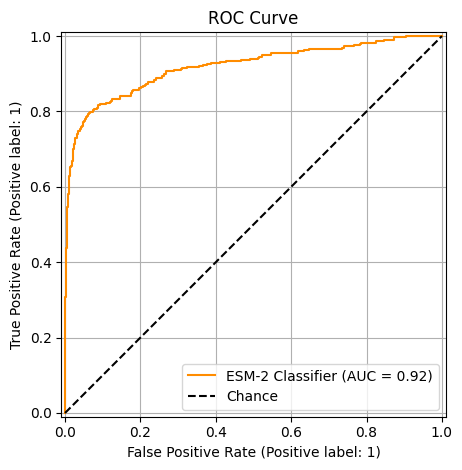

In [ ]:
# Plot the ROC curve
RocCurveDisplay.from_predictions(
    y_true=y_true,
    y_pred=y_prob,
    name="ESM-2 Classifier",
    color="darkorange"
)

plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Optional: reference line
plt.title("ROC Curve")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [26]:
def perform_y_scrambling(model_fn, train_data, test_data, best_params, device, n_iterations=5):
    """
    Perform Y-scrambling to validate the model's performance using the test dataset.

    Args:
        model_fn: Function to create a new model
        train_data: Training dataset
        test_data: Test dataset for evaluation
        best_params: Best hyperparameters from optimization
        device: Device as string ("cuda" or "cpu")
        n_iterations: Number of scrambling iterations

    Returns:
        Tuple of real_scores and scrambled_scores
    """
    print("\n🔀 Performing Y-Scrambling Analysis")
    real_scores = []
    scrambled_scores = []

    # Create DataLoader for test dataset (evaluation)
    eval_loader = DataLoader(test_data, batch_size=best_params["batch_size"],
                             collate_fn=collate_fn)

    # --- Train real model on unshuffled data (once) ---
    real_train_loader = DataLoader(train_data, batch_size=best_params["batch_size"],
                                   shuffle=True, collate_fn=collate_fn)

    def train_model(train_loader):
        esm_model, _ = esm.pretrained.esm2_t6_8M_UR50D()
        esm_model = esm_model.to(device)
        model = model_fn(esm_model).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=best_params["lr"])
        criterion = nn.BCEWithLogitsLoss()
        scaler = GradScaler()

        for _ in range(best_params["max_epochs"]):
            train_epoch(model, train_loader, criterion, optimizer, scaler, device)

        return model

    print("\n🔁 Training real model for comparison...")
    real_model = train_model(real_train_loader)
    criterion = nn.BCEWithLogitsLoss()
    real_metrics, real_y_true, real_y_prob = evaluate(real_model, eval_loader, criterion, device)
    real_scores.append(real_metrics["auc"])

    # --- Perform scrambling ---
    for i in range(n_iterations):
        print(f"\nScrambling Iteration {i+1}/{n_iterations}")

        # Get sequences and labels from training data
        train_seqs, train_labels = zip(*train_data)

        # Shuffle labels
        shuffled_labels = random.sample(train_labels, len(train_labels))

        # Create new dataset that returns (x, y) tuples
        scrambled_data = ProteinDataset(train_seqs, shuffled_labels, max_length=MAX_LEN)

        # Use the same collate_fn to ensure format matches original training
        scrambled_loader = DataLoader(scrambled_data, batch_size=best_params["batch_size"],
                                      shuffle=True, collate_fn=collate_fn)

        # Train model on scrambled labels
        scrambled_model = train_model(scrambled_loader)
        scrambled_metrics, scrambled_y_true, scrambled_y_prob  = evaluate(scrambled_model, eval_loader, criterion, device)
        scrambled_scores.append(scrambled_metrics["auc"])

        print(f"Real AUC: {real_scores[0]:.4f}, Scrambled AUC: {scrambled_scores[-1]:.4f}")

    # --- Plot ---
    plt.figure(figsize=(10, 6))
    plt.axhline(y=real_scores[0], color='r', linestyle='-', label=f'Real Data (AUC={real_scores[0]:.4f})')
    plt.axhline(y=0.5, color='k', linestyle='--', label='Random Chance')
    plt.plot(range(1, n_iterations+1), scrambled_scores, 'bo-', label='Scrambled Data')
    plt.xlabel('Iteration')
    plt.ylabel('AUC-ROC Score')
    plt.title('Y-Scrambling Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('y_scrambling_results.png')
    plt.show()

    # --- Summary ---
    mean_scrambled = np.mean(scrambled_scores)
    std_scrambled = np.std(scrambled_scores)

    print(f"\nY-Scrambling Results:")
    print(f"Real Data AUC: {real_scores[0]:.4f}")
    print(f"Scrambled Data Mean AUC: {mean_scrambled:.4f} ± {std_scrambled:.4f}")
    print(f"Performance Gap: {real_scores[0] - mean_scrambled:.4f}")

    if real_scores[0] > mean_scrambled + 2 * std_scrambled:
        print("✅ The model performance is significantly better than random chance.")
    else:
        print("⚠️ The model may be finding patterns in random noise.")

    return real_scores, scrambled_scores


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Now perform Y-scrambling to validate the model's performance
print("\n🔍 Validating model with Y-scrambling...")
real_scores, scrambled_scores = perform_y_scrambling(
    create_best_model,
    final_train_dataset,
    test_dataset,
    best_params,
    device=device,
    n_iterations=5, #add more interations later
)


In [ ]:
# Save the model including additional metadata for interpretability
torch.save({
    'model_state_dict': final_model.state_dict(),
    'esm_model_name': 'esm2_t6_8M_UR50D',  # Store which ESM version was used
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': best_params,
    'test_metrics': final_metrics,
    'alphabet': alphabet.__dict__,  # Save alphabet for correct tokenization later
    'model_architecture': {
        'hidden_dim': best_params["hidden_dim"],
        'num_layers': best_params.get("num_layers", 1),
        'dropout': best_params["dropout"]
    }
}, 'fine-tuned_esm2_allergen_classifier-final_version.pt')

print("\n✅ Model training complete and saved to 'fine-tuned_esm2_allergen_classifier-final_version.pt'")
print("The saved model contains all necessary metadata for later interpretability analysis.")


✅ Model training complete and saved to 'fine-tuned_esm2_allergen_classifier-final_version-3.pt'
The saved model contains all necessary metadata for later interpretability analysis.


In case you want to evaluate the saved model later (maybe on different metrics or do Y-scrambling as a sanity check), please load the saved model in the following way:
1.   Pip install "fair-esm".
2.   Import all the libraries except Optuna.
3.   Run the cell that defines the Random seed and load the correct ESM-2 model and MAX_LEN.
4. Load the dataclass and ESMClassifier class.
5. Load function "def evaluate" (or "def perform y-scrambling").
6.  Run cells below sequentially.



In [12]:
# Load saved model
checkpoint_path = 'fine-tuned_esm2_allergen_classifier-final_version.pt'
checkpoint = torch.load(checkpoint_path, map_location='cuda', weights_only=False)

In [ ]:
test_csv_path = "/content/drive/MyDrive/algpred2_fine-tuning_test.csv"

df_test = pd.read_csv(test_csv_path)

# Extract sequences and labels
test_sequences = df_test["sequence"].tolist()
test_labels = df_test["label"].tolist()

test_dataset = ProteinDataset(test_sequences, test_labels, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"],
                        collate_fn=collate_fn)

In [14]:
# === Use stored hyperparameters to reconstruct model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_arch = checkpoint['model_architecture']
esm_model, _ = esm.pretrained.esm2_t6_8M_UR50D()
esm_model = esm_model.cuda()
final_model = ESMClassifier(
    esm_model=esm_model,
    hidden_dim=model_arch['hidden_dim'],
    num_layers=model_arch['num_layers'],
    dropout=model_arch['dropout']
)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model = final_model.cuda()
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Evaluate on Test set
print("\n📊 Final Evaluation on Test Set:")
final_metrics, y_true, y_prob = evaluate(final_model, test_loader, criterion, device)

<ipython-input-26-2ea61a6686b9>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🔍 Validating model with Y-scrambling...

🔀 Performing Y-Scrambling Analysis

🔁 Training real model for comparison...


Training: 100%|██████████| 3747/3747 [03:12<00:00, 19.45it/s, loss=0.0315, acc=0.9971]


loss        : 0.9329
accuracy    : 0.8049
auc         : 0.9240
f1          : 0.7616
precision   : 0.9788
recall      : 0.6232
specificity : 0.9865
mcc         : 0.6544

Scrambling Iteration 1/5


<ipython-input-26-2ea61a6686b9>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training: 100%|██████████| 3747/3747 [03:12<00:00, 19.48it/s, loss=0.0745, acc=0.7452]
<ipython-input-26-2ea61a6686b9>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


loss        : 0.8789
accuracy    : 0.4730
auc         : 0.4906
f1          : 0.4448
precision   : 0.4699
recall      : 0.4222
specificity : 0.5238
mcc         : -0.0543
Real AUC: 0.9240, Scrambled AUC: 0.4906

Scrambling Iteration 2/5


Training: 100%|██████████| 3747/3747 [03:12<00:00, 19.44it/s, loss=0.1880, acc=0.7442]
<ipython-input-26-2ea61a6686b9>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


loss        : 0.8632
accuracy    : 0.5416
auc         : 0.5358
f1          : 0.5489
precision   : 0.5403
recall      : 0.5578
specificity : 0.5254
mcc         : 0.0833
Real AUC: 0.9240, Scrambled AUC: 0.5358

Scrambling Iteration 3/5


Training: 100%|██████████| 3747/3747 [03:13<00:00, 19.38it/s, loss=0.7395, acc=0.7532]
<ipython-input-26-2ea61a6686b9>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


loss        : 0.7952
accuracy    : 0.5770
auc         : 0.5977
f1          : 0.5721
precision   : 0.5789
recall      : 0.5654
specificity : 0.5886
mcc         : 0.1541
Real AUC: 0.9240, Scrambled AUC: 0.5977

Scrambling Iteration 4/5


Training: 100%|██████████| 3747/3747 [03:13<00:00, 19.33it/s, loss=0.3687, acc=0.7404]
<ipython-input-26-2ea61a6686b9>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


loss        : 0.8291
accuracy    : 0.5095
auc         : 0.5491
f1          : 0.4854
precision   : 0.5104
recall      : 0.4627
specificity : 0.5562
mcc         : 0.0190
Real AUC: 0.9240, Scrambled AUC: 0.5491

Scrambling Iteration 5/5


Training: 100%|██████████| 3747/3747 [03:13<00:00, 19.35it/s, loss=0.5836, acc=0.6671]


loss        : 0.7193
accuracy    : 0.5276
auc         : 0.5528
f1          : 0.4925
precision   : 0.5320
recall      : 0.4584
specificity : 0.5968
mcc         : 0.0557
Real AUC: 0.9240, Scrambled AUC: 0.5528


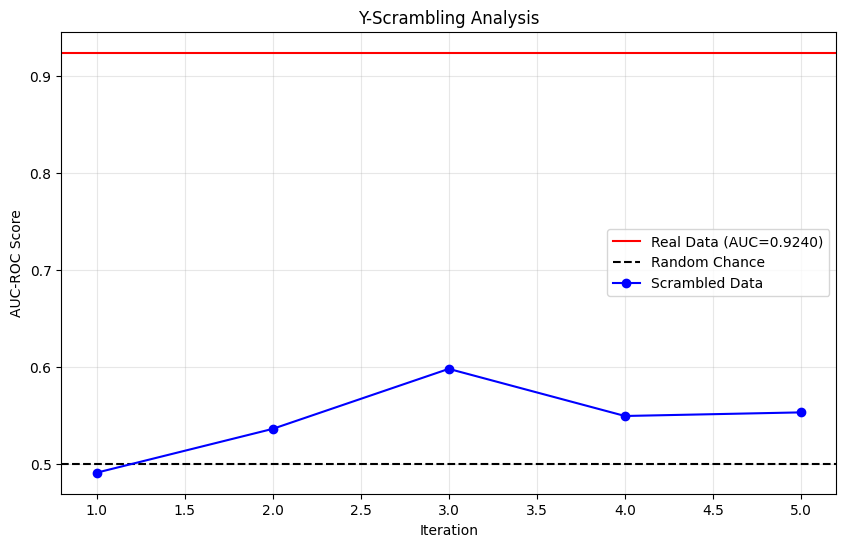


Y-Scrambling Results:
Real Data AUC: 0.9240
Scrambled Data Mean AUC: 0.5452 ± 0.0344
Performance Gap: 0.3787
✅ The model performance is significantly better than random chance.


In [27]:
# --- Define a model constructor to match the saved architecture ---
def model_fn(esm_model):
    return ESMClassifier(
        esm_model=esm_model,
        hidden_dim=model_arch['hidden_dim'],
        num_layers=model_arch['num_layers'],
        dropout=model_arch['dropout']
    )
device = "cuda" if torch.cuda.is_available() else "cpu"
# --- Run Y-scrambling ---
print("\n🔍 Validating model with Y-scrambling...")
real_scores, scrambled_scores = perform_y_scrambling(
    model_fn=model_fn,
    train_data=final_train_dataset,
    test_data=test_dataset,
    best_params=best_params,
    device=device,
    n_iterations=5
)


In [ ]:
# Create the ROC display object and plot it
RocCurveDisplay.from_predictions(
    y_true=y_true,
    y_pred=y_prob,
    name="ESM-2 Classifier",
    color="darkorange"
)

plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Optional: reference line
plt.title("ROC Curve")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()